/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


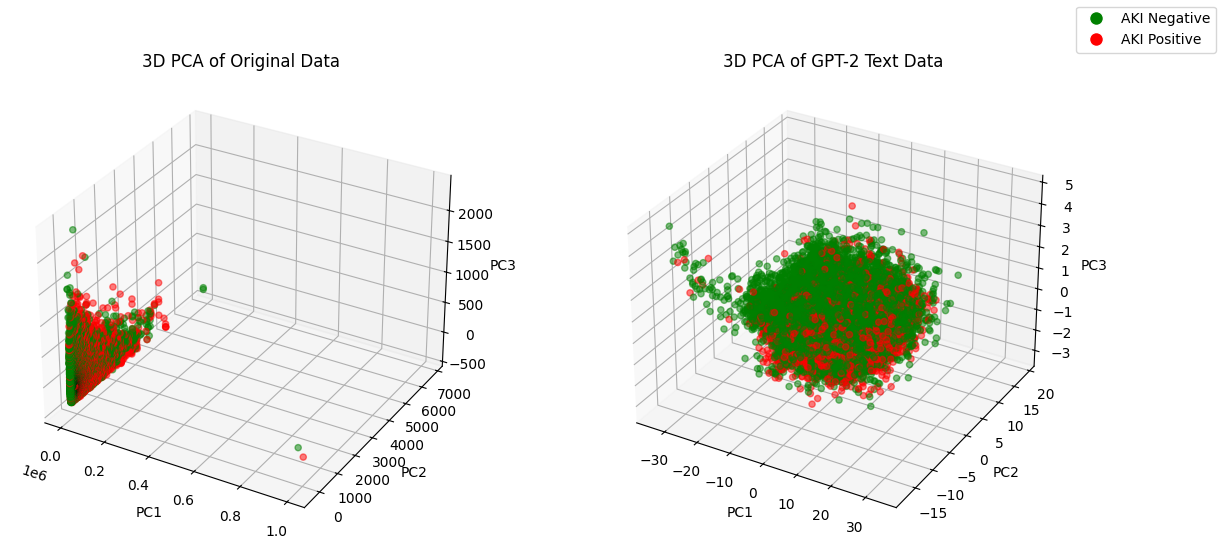

In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import torch
import random
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Function to set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
df = pd.read_csv("/home/ubuntu/AKI/analysis_without_urine_aki.csv")

# Pre-process the data
def data_pre_processing(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    numeric_transformer = SimpleImputer(strategy='mean')
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    df_processed = preprocessor.fit_transform(df)
    
    cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_cols = numeric_features + list(cat_cols)
    
    df_final = pd.DataFrame(df_processed, columns=all_cols)
    return df_final

new_df = data_pre_processing(df)
y = new_df['AKI_7DAY'].values.astype(int)
new_df = new_df.drop('AKI_7DAY', axis='columns')

def row_to_sentence_full(row):
    sentence_parts = []
    
    if not pd.isna(row['AGE']):
        sentence_parts.append(f"A patient of age {row['AGE']}")
    
    numeric_cols = [
        'ALBUMIN_MAX', 'ALBUMIN_MIN', 'ANIONGAP_MAX', 'ANIONGAP_MIN', 'BANDS_MAX', 'BANDS_MIN',
        'BICARBONATE_MAX', 'BICARBONATE_MIN', 'BILIRUBIN_MAX', 'BILIRUBIN_MIN', 'BUN_MAX', 'BUN_MIN',
        'CHLORIDE_MAX', 'CHLORIDE_MIN', 'CREAT', 'CREATININE_MAX', 'CREATININE_MIN', 'DIASBP_MAX',
        'DIASBP_MEAN', 'DIASBP_MIN', 'EGFR', 'GLUCOSE_MAX_x', 'GLUCOSE_MAX_y', 'GLUCOSE_MEAN',
        'GLUCOSE_MIN_x', 'GLUCOSE_MIN_y', 'HEARTRATE_MAX', 'HEARTRATE_MEAN', 'HEARTRATE_MIN',
        'HEMATOCRIT_MAX', 'HEMATOCRIT_MIN', 'HEMOGLOBIN_MAX', 'HEMOGLOBIN_MIN', 'INR_MAX', 'INR_MIN',
        'LACTATE_MAX', 'LACTATE_MIN', 'MEANBP_MAX', 'MEANBP_MEAN', 'MEANBP_MIN', 'PLATELET_MAX',
        'PLATELET_MIN', 'POTASSIUM_MAX', 'POTASSIUM_MIN', 'PTT_MAX', 'PTT_MIN', 'PT_MAX', 'PT_MIN',
        'RESPRATE_MAX', 'RESPRATE_MEAN', 'RESPRATE_MIN', 'SODIUM_MAX', 'SODIUM_MIN', 'SPO2_MAX',
        'SPO2_MEAN', 'SPO2_MIN', 'SYSBP_MAX', 'SYSBP_MEAN', 'SYSBP_MIN', 'TEMPC_MAX', 'TEMPC_MEAN',
        'TEMPC_MIN', 'WBC_MAX', 'WBC_MIN'
    ]

    for col in numeric_cols:
        if not pd.isna(row[col]):
            sentence_parts.append(f"{col.replace('_', ' ').lower()} of {row[col]}")

    conditions = [
        'ALCOHOL_ABUSE', 'CARDIAC_ARRHYTHMIAS', 'CONGESTIVE_HEART_FAILURE', 'DIABETES_COMPLICATED',
        'DIABETES_UNCOMPLICATED', 'DRUG_ABUSE', 'HYPERTENSION', 'HYPOTHYROIDISM', 'LIVER_DISEASE',
        'OBESITY', 'PERIPHERAL_VASCULAR', 'RENAL_FAILURE', 'VALVULAR_DISEASE'
    ]
    for condition in conditions:
        if row.get(condition, 0) == 1:
            sentence_parts.append(f"has {condition.replace('_', ' ').lower()}")

    ethnicity_cols = [col for col in row.index if "ETHNICITY_" in col]
    for col in ethnicity_cols:
        if row.get(col, 0) == 1:
            sentence_parts.append(f"identified as {col.replace('ETHNICITY_', '').replace('_', ' ').lower()}")

    if row.get('GENDER_F', 0) == 1:
        sentence_parts.append("gender is female")
    elif row.get('GENDER_M', 0) == 1:
        sentence_parts.append("gender is male")

    if not sentence_parts:
        return "No data available for this patient."
    
    return ', '.join(sentence_parts) + '.'

texts = new_df.apply(row_to_sentence_full, axis=1).tolist()
labels = y.tolist()

data = {'text': texts, 'label': labels}
new_df_llm = pd.DataFrame(data)

# Generate embeddings using GPT-2
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to eos_token if padding token is not defined
model = AutoModelForSequenceClassification.from_pretrained('gpt2', num_labels=2, output_hidden_states=True).to(device)

def get_gpt2_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states[-1]
    return hidden_states.mean(dim=1).cpu().numpy().flatten()

# Create a function to apply get_gpt2_embeddings to the DataFrame
def apply_embeddings(text_series):
    embeddings = []
    for text in text_series:
        embeddings.append(get_gpt2_embeddings(text))
    return embeddings

new_df_llm['embeddings'] = apply_embeddings(new_df_llm['text'])

# Convert embeddings to array for PCA
text_embeddings = np.vstack(new_df_llm['embeddings'])

# Apply PCA
pca_orig = PCA(n_components=3)
pca_text = PCA(n_components=3)

pca_orig_fit = pca_orig.fit_transform(new_df)
pca_text_fit = pca_text.fit_transform(text_embeddings)

# 3D PCA Plot
fig = plt.figure(figsize=(14, 6))

# Plot for Original Data
ax1 = fig.add_subplot(121, projection='3d')
colors = np.where(y == 0, 'green', 'red')
sc1 = ax1.scatter(pca_orig_fit[:, 0], pca_orig_fit[:, 1], pca_orig_fit[:, 2], c=colors, alpha=0.5)
ax1.set_title('3D PCA of Original Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# Plot for GPT-2 Text Data
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(pca_text_fit[:, 0], pca_text_fit[:, 1], pca_text_fit[:, 2], c=colors, alpha=0.5)
ax2.set_title('3D PCA of GPT-2 Text Data')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

# Add legend
green_patch = plt.Line2D([0], [0], marker='o', color='w', label='AKI Negative', markerfacecolor='green', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='AKI Positive', markerfacecolor='red', markersize=10)
fig.legend(handles=[green_patch, red_patch], loc='upper right')

# Save figure in high quality
plt.savefig('pca_3d_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('pca_3d_comparison.pdf', dpi=300, bbox_inches='tight')

plt.show()
